# Example: Hilbert space approximation for Gaussian processes (multidimensional)


Gaussian process models (see [Example: Gaussian Process](https://num.pyro.ai/en/stable/examples/gp.html)) are a flexible class of models for regression, classification, and unsupervised learning. Because they have poor scaling properties, they are not suitable for large datasets. The Hilbert space approximation (see [Example: Hilbert space approximation for Gaussian processes](https://num.pyro.ai/en/stable/examples/hsgp.html)) provides a scalable alternative. This example extends the univariate case studied in the previous example to the multidimensional input case and demonstrates the usage of the [contributed HSGP module](https://num.pyro.ai/en/stable/contrib.html#hilbert-space-gaussian-processes-approximation).

First, load the required libraries and set configure `jax` and `numpyro`.

In [16]:
from typing import Sequence

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from numpy.typing import NDArray

import jax
from jax import random
import jax.numpy as jnp
from optax import linear_onecycle_schedule

import numpyro
from numpyro import distributions as dist
from numpyro.contrib.hsgp.approximation import hsgp_squared_exponential
from numpyro.infer import Predictive
from numpyro.infer.autoguide import AutoNormal
from numpyro.infer.elbo import Trace_ELBO
from numpyro.infer.hmc import NUTS
from numpyro.infer.initialization import init_to_median
from numpyro.infer.mcmc import MCMC
from numpyro.infer.svi import SVI
from numpyro.optim import Adam

In [6]:
num_devices = 4
numpyro.set_host_device_count(num_devices)
jax.config.update(
    "jax_enable_x64", True
)  # additional precision for to avoid numerical issues with Cholesky decomposition of the covariance matrix

## Draw Simulated Data

We begin by sampling `N` points from a `D`-dimensional Gaussian process with a squared exponential kernel function. The input points are drawn from a uniform distribution on a square/hypercube spanning the domain $[-L, L]^D$. We also sample a (noise-free) set of points from a uniformly-spaced grid of inputs in order to visualize the generative process. Because our model will assume that the Gaussian process is centered, we de-mean points in the output space prior to returning them. The `sample_grid_and_data` function returns the gridded values and the data points. The `se_kernel` function implements the covariance function for the Gaussian process.

In [7]:
def se_kernel(
    X: jax.Array,
    Z: jax.Array,
    amplitude: float,
    length: float,
    noise: float | None,
    jitter=1.0e-6,
) -> jax.Array:
    """Squared exponential kernel function."""
    r = jnp.linalg.norm(X[:, jnp.newaxis] - Z, axis=-1)
    delta = (r / length) ** 2
    k = (amplitude**2) * jnp.exp(-0.5 * delta)
    if noise is None:
        return k
    else:
        return k + (noise**2 + jitter) * jnp.eye(k.shape[0])


def sample_grid_and_data(
    N_grid: int,
    N: int,
    L: float,
    amplitude: float,
    lengthscale: float,
    noise: float,
    key: int,
    D: int,
) -> tuple[jax.Array, jax.Array, jax.Array, jax.Array]:
    """Sample N_grid ** D points from noiseless function and N noisy data points from a GP."""

    # draw points on a grid for plotting surface of the noiseless function
    x_linspace = jnp.linspace(-L, L, N_grid)
    x_mesh = jnp.meshgrid(*[x_linspace for _ in range(D)])
    X_grid = jnp.concatenate([x_mesh[i].ravel()[..., None] for i in range(D)], axis=1)

    # draw data points from a uniform distribution on the support of the grid
    X = random.uniform(key, shape=(N, D), minval=-L, maxval=L)

    # concatenate grid and data points
    X_all = jnp.concatenate([X_grid, X], axis=0)

    # sample from the GP
    cov = se_kernel(X_all, X_all, amplitude, lengthscale, 0.0)  # noiseless
    _, key = random.split(key)
    _y = random.multivariate_normal(key, mean=jnp.zeros(cov.shape[0]), cov=cov)

    # separate the grid and data points
    y_grid = _y[0 : N_grid**D].reshape((N_grid,) * D)
    _, key = random.split(key)
    y = _y[N_grid**D :] + (
        random.normal(key, shape=(N,)) * noise
    )  # add noise to the data points

    y_mean = y.mean()

    return X_grid, y_grid - y_mean, X, y - y_mean

We fix `D=2` for this example but the code is fully general. Plots will be rendered for the unidimensional and bidimensional cases. We set `N=1000` and `L=3.0`. 

In [8]:
# parameters for the synthetic data
D = 2
N_grid = 25 if D == 2 else 100
N = 1_000
L = 3.0

# kernel parameters
amplitude = 1.0
lengthscale = 2.0

# noise level
noise = 0.5 if D == 2 else 0.15

# sample the grid and data
seed = 0
key = jax.random.key(seed)

X_grid, y_grid, X, y = sample_grid_and_data(
    N_grid, N, L, amplitude, lengthscale, noise, key, D
)

Before proceeding to the models, we'll set up a few plotting functions to help visualize the generative process and the posterior predictive distribution. We'll use `plot_surface_scatter` in the 2 dimensional case and `plot_line_scatter` in the 1 dimensional case.

In [9]:
def plot_surface_scatter(
    N_grid: int,
    X_grid: NDArray | None = None,
    y_grid: NDArray | None = None,
    X: NDArray | None = None,
    y: NDArray | None = None,
    test_ind: jax.Array | None = None,
    post_y: jax.Array | None = None,
    xz_lines: list[tuple[jax.Array, jax.Array, float]] | None = None,
    yz_lines: list[tuple[jax.Array, jax.Array, float]] | None = None,
    xy_annotate_lines: Sequence[
        tuple[tuple[float, float], tuple[float, float]] | None
    ] = None,
    fig_size: float = 8.0,
    label_size: float = 8.0,
    grid_alpha: float = 0.1,
    y_wireframe_alpha: float = 1.0,
    post_alpha: float = 0.1,
    point_size: float = 1.0,
    point_alpha: float = 0.5,
    ci_alpha: float = 0.1,
) -> None:
    # setup figure
    fig = plt.figure(figsize=(fig_size, fig_size))

    # plot the surface of the noiseless function and the data points
    x0_grid, x1_grid = (
        X_grid[:, 0].reshape((N_grid, N_grid)),
        X_grid[:, 1].reshape((N_grid, N_grid)),
    )
    ax = fig.add_subplot(projection="3d")

    # plot wireframes from draws from the posterior
    if post_y is not None:
        for i in range(post_y.shape[0]):
            post_y_grid = post_y[i, :].reshape((N_grid, N_grid))
            ax.plot_wireframe(
                x0_grid,
                x1_grid,
                post_y_grid,
                rstride=1,
                cstride=1,
                linewidth=1.0,
                alpha=post_alpha,
                color="tab:blue",
            )

    # plot the data points
    if X is not None and y is not None:
        color = (
            "tab:blue"
            if test_ind is None
            else np.where(test_ind, "tab:green", "tab:blue")
        )
        ax.scatter(
            xs=X[:, 0],
            ys=X[:, 1],
            zs=y,
            c=color,
            s=point_size,
            alpha=point_alpha,
        )

    # add confidence intervals at the boundaries
    if xz_lines:
        for line in xz_lines:
            x, z, y = line
            ax.plot(
                x, z, zs=y, zdir="y", color="tab:green", linestyle="--", alpha=ci_alpha
            )
    if yz_lines:
        for line in yz_lines:
            y, z, x = line
            ax.plot(
                y, z, zs=x, zdir="x", color="tab:green", linestyle="--", alpha=ci_alpha
            )

    # plot the surface of the noiseless function
    if y_grid is not None:
        ax.plot_wireframe(
            x0_grid,
            x1_grid,
            y_grid,
            rstride=1,
            cstride=1,
            linewidths=1.0,
            alpha=y_wireframe_alpha,
            color="tab:orange",
        )

    # add box in xy plane
    z_min = ax.get_zlim()[0]
    ax.set_zlim(ax.get_zlim())
    if xy_annotate_lines:
        for line in xy_annotate_lines:
            x_bounds, y_bounds = line
            z_bounds = (z_min, z_min)
            ax.plot(
                x_bounds,
                y_bounds,
                z_bounds,
                color="tab:gray",
                alpha=0.5,
                linestyle="--",
            )

    # remove background panes
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor("w")
    ax.yaxis.pane.set_edgecolor("w")
    ax.zaxis.pane.set_edgecolor("w")

    # configure grid
    ax.xaxis._axinfo["grid"]["color"] = ("tab:gray", grid_alpha)
    ax.yaxis._axinfo["grid"]["color"] = ("tab:gray", grid_alpha)
    ax.zaxis._axinfo["grid"]["color"] = ("tab:gray", grid_alpha)

    # set labels and ticks
    ax.xaxis.set_tick_params(labelsize=label_size)
    ax.set_xlabel("x0", fontsize=label_size)
    ax.yaxis.set_tick_params(labelsize=label_size)
    ax.set_ylabel("x1", fontsize=label_size)
    ax.zaxis.set_tick_params(labelsize=label_size)
    ax.set_zlabel("y", fontsize=label_size)

    ax.set_box_aspect(aspect=None, zoom=0.9)
    return ax


def plot_line_scatter(
    X_grid: jax.Array,
    y_grid: jax.Array,
    X: jax.Array | None = None,
    y: jax.Array | None = None,
    test_ind: jax.Array | None = None,
    post_y: jax.Array | None = None,
    v_lines: Sequence[float] | None = None,
    ci: tuple[jax.Array, jax.Array] | None = None,
    fig_size: float = 5.0,
    label_size: float = 8.0,
    post_alpha: float = 0.25,
    point_size: float = 1.0,
    point_alpha: float = 0.25,
    ci_alpha: float = 0.1,
):
    fig = plt.figure(figsize=(fig_size, fig_size))
    ax = fig.add_subplot()

    # plot draws of the function from the posterior
    if post_y is not None:
        for i in range(post_y.shape[0]):
            ax.plot(
                X_grid, post_y[i, :], linewidth=1.0, alpha=post_alpha, color="tab:blue"
            )

    # plot the data points
    if X is not None and y is not None:
        if test_ind is None:
            color = "tab:blue"
        else:
            test_ind = np.array(test_ind).squeeze()
            color = np.where(test_ind, "tab:green", "tab:blue")
        ax.scatter(X, y, c=color, s=point_size, alpha=point_alpha)

    # add confidence intervals
    if ci:
        ax.fill_between(
            X_grid.squeeze(), ci[0], ci[1], color="tab:blue", alpha=ci_alpha
        )

    # add the noiseless function
    ax.plot(X_grid, y_grid, linewidth=1.0, alpha=1.0, color="tab:orange")

    # add vertical lines denoting boundaries of the training data
    if v_lines:
        for v_line in v_lines:
            plt.axvline(v_line, color="tab:gray", linestyle="--", alpha=0.5)
            plt.axvline(v_line, color="tab:gray", linestyle="--", alpha=0.5)

    # set labels and ticks
    ax.set_xlabel("x", fontsize=label_size)
    ax.set_ylabel("y", fontsize=label_size)
    ax.xaxis.set_tick_params(labelsize=label_size)
    ax.yaxis.set_tick_params(labelsize=label_size)

    return ax

We can plot the surface of the noise-free function as a wireframe and the noisy observations as points.

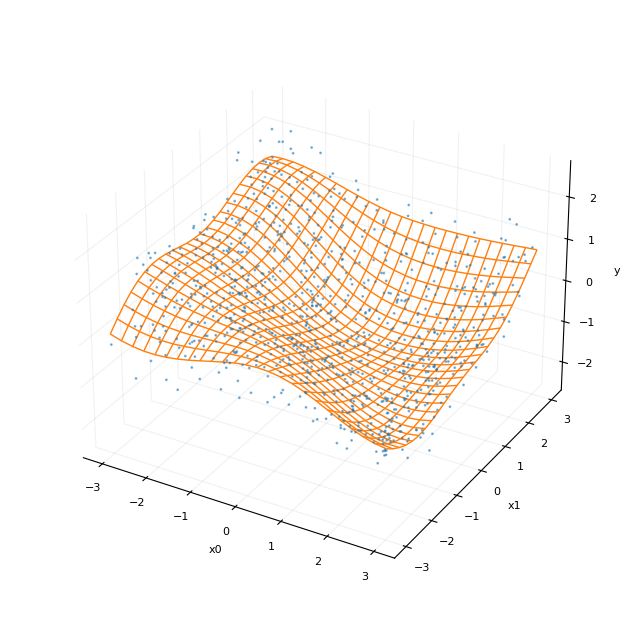

In [10]:
if D == 2:
    plot_surface_scatter(N_grid, X_grid, y_grid, X, y)
elif D == 1:
    plot_line_scatter(
        X_grid,
        y_grid,
        X,
        y,
    )
plt.show()

## Exact covariance Gaussian process (baseline)

We begin by fitting an exact Gaussian process model to the noisy points. We infer the hyperparameters of the kernel function and the noise level. To compute the covariance function, we can re-use the `se_kernel` function from above. Because exact Gaussian process models require persisting the train set, we store the training data `X` and `y` as attributes on the model so that we can compute the posterior predictive distribution later. When `X_test` is provided, `f_star` and `y_test` are returned as outputs, corresponding to the posterior mean and the samples from the noisy emission distribution at the test points.

In [11]:
@jax.tree_util.register_pytree_node_class  # https://github.com/google/jax/discussions/16020
class GPModel:
    """Exact GP model with a squared exponential kernel."""

    def __init__(self, X: jax.Array, y: jax.Array):
        self.X = X
        self.y = y

    def model(self, X_test: jax.Array | None = None):
        amplitude = numpyro.sample("amplitude", dist.LogNormal(0, 1))
        length = numpyro.sample("lengthscale", dist.Exponential(1))
        noise = numpyro.sample("noise", dist.LogNormal(0, 1))

        k = se_kernel(self.X, self.X, amplitude, length, noise)

        if X_test is not None:  # predictive distribution
            k_inv = jnp.linalg.inv(k)
            k_star = se_kernel(X_test, self.X, amplitude, length, noise=None)
            k_star_star = se_kernel(X_test, X_test, amplitude, length, noise)

            f_star = numpyro.deterministic("f_star", k_star @ (k_inv @ self.y))
            cov_star = k_star_star - (k_star @ k_inv @ k_star.T)
            numpyro.sample(
                "y_test",
                dist.MultivariateNormal(loc=f_star, covariance_matrix=cov_star),
            )
        else:
            numpyro.sample(
                "y", dist.MultivariateNormal(loc=0, covariance_matrix=k), obs=self.y
            )

    def tree_flatten(self):
        children = (self.X, self.y)  # arrays / dynamic values
        aux_data = {}  # static values
        return (children, aux_data)

    @classmethod
    def tree_unflatten(cls, aux_data, children):
        return cls(*children, **aux_data)

Before fitting the model, we split the data into train and test sets. We will train on the data set away from the boundary and test the model's ability to extrapolate to the boundary.

In [12]:
tr_frac = 0.8  # train on data contained within the inner tr_frac fraction of the domain
tr_idx = ((X > -L * tr_frac) & (X < L * tr_frac)).sum(axis=1) == D
tr_idx_grid = ((X_grid > -L * tr_frac) & (X_grid < L * tr_frac)).sum(axis=1) == D

X_tr = X[tr_idx]  # train on values set away from the edges
X_test = X[~tr_idx]
y_tr = y[tr_idx]
y_test = y[~tr_idx]

m = GPModel(X_tr, y_tr)

`fit_mcmc` and `fit_svi` are helper functions that do inference on the model using MCMC and SVI, respectively. We will use MCMC here, but we can easily switch to `SVI` to achieve faster inference under a mean-field approximation of the posterior.

In [13]:
INFERENCE = "mcmc"


def fit_mcmc(seed: int, model: callable, **model_kwargs):
    rng_key = random.PRNGKey(seed)
    kernel = NUTS(model)
    mcmc = MCMC(
        kernel, num_warmup=500, num_samples=500, num_chains=4, progress_bar=False
    )
    mcmc.run(rng_key, **model_kwargs)
    return mcmc


def fit_svi(
    seed: int,
    model: callable,
    guide: callable,
    num_steps: int = 5000,
    peak_lr: float = 0.01,
    **model_kwargs,
):
    lr_scheduler = linear_onecycle_schedule(num_steps, peak_lr)
    svi = SVI(model, guide, Adam(lr_scheduler), Trace_ELBO())
    return svi.run(random.PRNGKey(seed), num_steps, progress_bar=False, **model_kwargs)


if INFERENCE == "mcmc":
    mcmc = fit_mcmc(seed, m.model)
else:
    guide = AutoNormal(m.model, init_loc_fn=init_to_median(num_samples=25))
    svi_res = fit_svi(seed=seed, model=m.model, guide=guide)

We see that the model accurately recovers the generative kernel hyperparameters. (Recall that the value of the kernel `amplitude` was set to 1.0 and the `lengthscale` was set to 2.0)

In [33]:
if INFERENCE == "mcmc":
    idata = az.from_numpyro(posterior=mcmc)
    mcmc.print_summary()


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
    amplitude      1.31      0.57      1.17      0.58      2.11    868.30      1.00
  lengthscale      2.37      0.50      2.33      1.56      3.14    925.36      1.00
        noise      0.49      0.01      0.49      0.47      0.52   1307.16      1.00

Number of divergences: 0


Inspecting the individual chains demonstrates convergence.

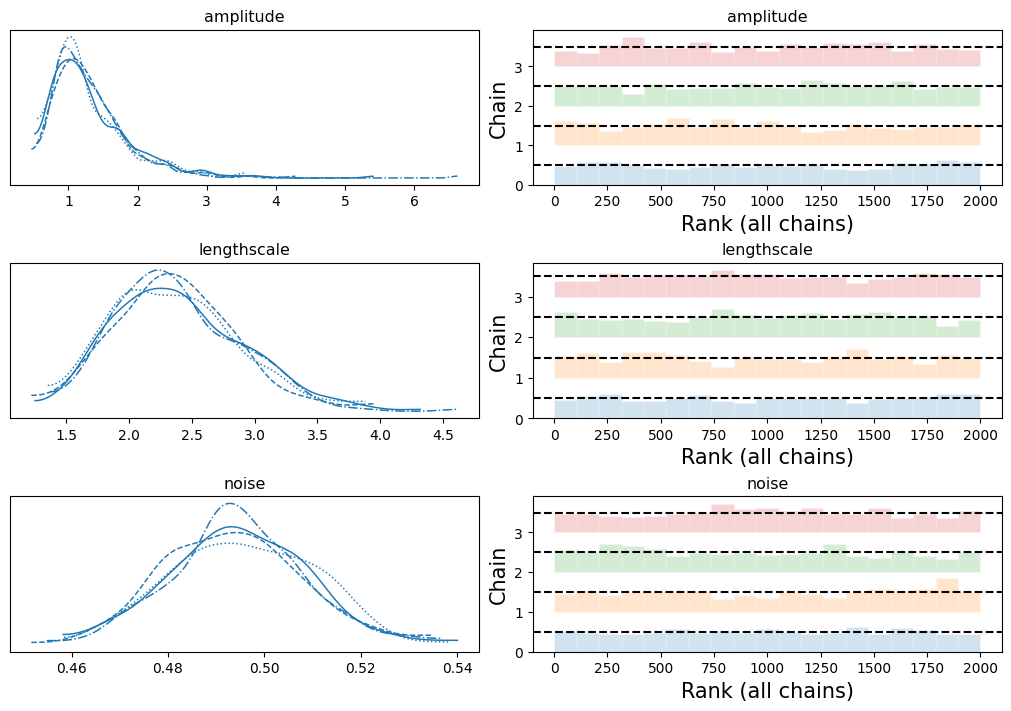

In [21]:
if INFERENCE == "mcmc":
    VAR_NAMES = ["amplitude", "lengthscale", "noise"]
    axes = az.plot_trace(
        data=idata,
        var_names=VAR_NAMES,
        kind="rank_bars",
        backend_kwargs={"figsize": (10, 7), "layout": "constrained"},
    )

Now, we can set up helper functions to generate draws from the posterior predictive and assess the model's ability to recover the known functional form and extrapolate to the boundary.

In [22]:
def posterior_predictive_mcmc(
    seed: int,
    model: callable,
    mcmc: MCMC,
    **model_kwargs,
) -> dict[str, jax.Array]:
    samples = mcmc.get_samples()
    predictive = Predictive(model, samples, parallel=True)
    return predictive(random.PRNGKey(seed), **model_kwargs)


def posterior_predictive_svi(
    seed: int,
    model: callable,
    guide: callable,
    params: dict,
    num_samples: int = 2000,
    **model_kwargs,
) -> dict[str, jax.Array]:
    predictive = Predictive(model, guide=guide, params=params, num_samples=num_samples)
    return predictive(random.PRNGKey(seed), **model_kwargs)

Using the posterior samples, we can predict the values of the function on the set of grid points and test its ability to recover the true function.

In [23]:
if INFERENCE == "mcmc":
    post_y = posterior_predictive_mcmc(seed, m.model, mcmc, X_test=X_grid)
else:
    post_y = posterior_predictive_svi(
        seed, m.model, guide, svi_res.params, X_test=X_grid
    )

With posterior predictive samples drawn from the model, we can visualize samples of the latent function and the associated 80 percent credible intervals.

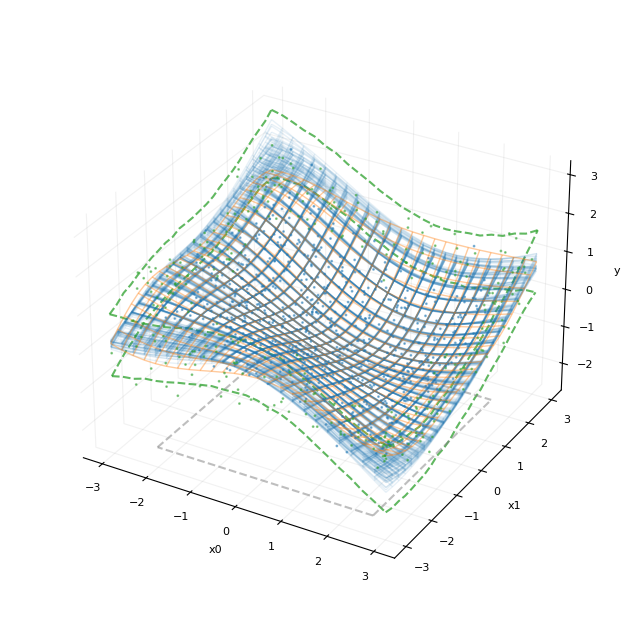

In [24]:
def plot_fit_result(
    N_post: int, post: dict[str, jax.Array], q_lower: float = 0.1, q_upper: float = 0.9
):
    ci = np.quantile(post["y_test"], jnp.array([q_lower, q_upper]), axis=0)
    if D == 1:
        ci_lower, ci_upper = ci[0, :], ci[1, :]
        test_ind = (X < -L * tr_frac) | (X > L * tr_frac)
        ax = plot_line_scatter(
            X_grid,
            y_grid,
            X,
            y,
            test_ind=test_ind,
            post_y=post["f_star"][0:N_post, :],
            post_alpha=0.1,
            point_alpha=0.15,
            v_lines=[-L * tr_frac, L * tr_frac],
            ci=(ci_lower, ci_upper),
            fig_size=5.0,
        )
    elif D == 2:
        # compute confidence intervals at the edges of the grid
        yz_ind1 = X_grid[:, 0] == L
        yz_lower1 = ci[0, :][yz_ind1]
        yz_upper1 = ci[1, :][yz_ind1]
        yz_ind2 = X_grid[:, 0] == -L
        yz_lower2 = ci[0, :][yz_ind2]
        yz_upper2 = ci[1, :][yz_ind2]

        xz_ind1 = X_grid[:, 1] == L
        xz_lower1 = ci[0, :][xz_ind1]
        xz_upper1 = ci[1, :][xz_ind1]
        xz_ind2 = X_grid[:, 1] == -L
        xz_lower2 = ci[0, :][xz_ind2]
        xz_upper2 = ci[1, :][xz_ind2]

        ax = plot_surface_scatter(
            N_grid=N_grid,
            X_grid=X_grid,
            y_grid=y_grid,
            X=X,
            y=y,
            test_ind=~tr_idx,
            post_y=post["f_star"][0:N_post, :],
            post_alpha=0.1,
            xy_annotate_lines=[
                ((-L * tr_frac, -L * tr_frac), (-L * tr_frac, L * tr_frac)),
                ((-L * tr_frac, L * tr_frac), (L * tr_frac, L * tr_frac)),
                ((L * tr_frac, L * tr_frac), (-L * tr_frac, L * tr_frac)),
                ((L * tr_frac, -L * tr_frac), (-L * tr_frac, -L * tr_frac)),
            ],
            yz_lines=[
                (X_grid[yz_ind1, 1], yz_lower1, L),
                (X_grid[yz_ind1, 1], yz_upper1, L),
                (X_grid[yz_ind2, 1], yz_lower2, -L),
                (X_grid[yz_ind2, 1], yz_upper2, -L),
            ],
            xz_lines=[
                (X_grid[xz_ind1, 0], xz_lower1, L),
                (X_grid[xz_ind1, 0], xz_upper1, L),
                (X_grid[xz_ind2, 0], xz_lower2, -L),
                (X_grid[xz_ind2, 0], xz_upper2, -L),
            ],
            y_wireframe_alpha=0.4,
            ci_alpha=0.75,
        )
    return ax


plot_fit_result(20, post_y)
plt.show()

Here, we plot several draws of the posterior mean (`f_star`) as blue wireframes overlaid on the true function in orange. The square in the x0-x1 plane denotes the region of data on which the model was trained. The green dashed lines on the function's boundary denote it's 80 percent credible intervals at the boundary points. We also plot the set of training points in blue and the set of test points in green.

We can also directly inspect the model's calibration against the set of grid points. The `plot_calibration` function compares the true function values to the posterior predictive mean.

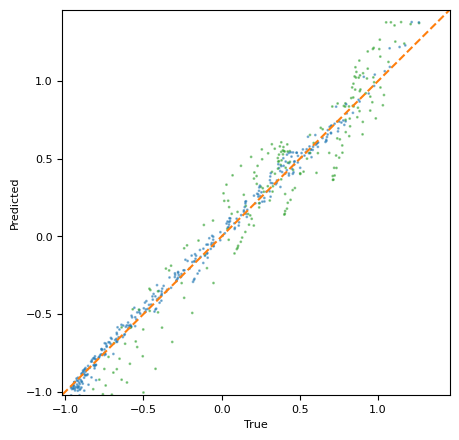

In [25]:
def plot_calibration(
    y_true: jax.Array,
    y_pred: jax.Array,
    test_ind: jax.Array | None = None,
    fig_size: float = 5.0,
    label_size: float = 8.0,
    point_size: float = 1.0,
    x_label: str = "True",
    y_label: str = "Predicted",
):
    fig = plt.figure(figsize=(fig_size, fig_size))
    ax = fig.add_subplot()
    color = (
        "tab:blue" if test_ind is None else np.where(test_ind, "tab:green", "tab:blue")
    )
    ax.scatter(y_true, y_pred, c=color, alpha=0.5, s=point_size)
    ax.plot(
        [y_true.min(), y_true.max()],
        [y_true.min(), y_true.max()],
        color="tab:orange",
        linestyle="--",
    )
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.xaxis.set_tick_params(labelsize=label_size)
    ax.set_xlabel(x_label, fontsize=label_size)
    ax.yaxis.set_tick_params(labelsize=label_size)
    ax.set_ylabel(y_label, fontsize=label_size)
    return ax


ax = plot_calibration(
    y_grid,
    post_y["f_star"].mean(axis=0),
    test_ind=~tr_idx_grid,
    point_size=1.0 if D == 2 else 5.0,
)
plt.show()

Grid points points included in the bounds of the test set are displayed in blue. Points outside the training boundary are displayed in green. The dashed line in orange is the identity line (True=predicted). 

Finally, as a benchmark to compare the HSGP approximation against, we compute the root mean squared error on the set of (noisy) test points.

In [26]:
if INFERENCE == "mcmc":
    post_y_test = posterior_predictive_mcmc(seed, m.model, mcmc, X_test=X_test)
else:
    post_y_test = posterior_predictive_svi(
        seed, m.model, guide, svi_res.params, X_test=X_test
    )
print(
    "Test RMSE:",
    jnp.sqrt(jnp.mean((post_y_test["y_test"].mean(axis=0) - y_test) ** 2)),
)

Test RMSE: 0.5625003036885073


## HSGP Alternative

We now turn to the Hilbert Space approximation. [Mayol et al 2020](https://arxiv.org/abs/2004.11408) provide an accessible and practical introduction to the methodology. [Orduz 2024](https://num.pyro.ai/en/stable/tutorials/hsgp_example.html) additionally provides a detailed tutorial with numpyro code for a unidimensional example. Below, we demonstrate the usage of the `numpyro.contrib.hsgp` module on a multidimensional problem. The full approximation is given by
$$
f(\boldsymbol{x}) = \sum_{j=1}^{m^\star} \left( S_{\theta}^\star \left( \sqrt{\boldsymbol{\lambda}_j^\star} \right) \right)^{\frac{1}{2}} \phi_j^\star(\boldsymbol{x}) \beta_j
$$
(Mayol et al 2020, Eq. 14)

Here, $S_{\theta}^\star$ is the spectral density of the squared exponential kernel, $\boldsymbol{\lambda}_j^\star$ are the eigenvalues of the Laplacian, $\phi_j^\star$ are the eigenfunctions of the Laplacian, and $\beta_j$ are the coefficients of the expansion ($\sim \mathcal{N}(0, 1)$). The total number of eigenfunctions is $m^\star$ which is the product of the number of approximating functions for each dimension.

This approximation is conveniently implemented by the `numpyro.contrib.hsgp.approximation` module's `hsgp_squared_exponential` function. For the full model, we can simply sample kernel hyperparameters, feed these to the `hsgp_squared_exponential` function, and define the emission distribution. The dimension of the problem is inferred from the trailing dimension of `X`. We set the number of basis functions for each dimension (`m`) to 5 and the support of the model (`[-L, L]`) to be 2.5 times the support of the data. If desired, we could pass length-`D` lists to `m` and `L` to allow the number of basis functions of the approximation and the length of the approximation interval to vary by dimension.

In [27]:
@jax.tree_util.register_pytree_node_class
class HSGPModel:
    def __init__(self, m: int, L: float) -> None:
        self.m = m
        self.L = L

    def model(
        self,
        X: jax.Array,
        y: jax.Array | None = None,
    ):
        amplitude = numpyro.sample("amplitude", dist.LogNormal(0, 1))
        length = numpyro.sample("lengthscale", dist.Exponential(1))
        noise = numpyro.sample("noise", dist.LogNormal(0, 1))

        f = numpyro.deterministic(
            "f_star",
            hsgp_squared_exponential(
                X, alpha=amplitude, length=length, ell=self.L, m=self.m
            ),
        )
        site = "y" if y is not None else "y_test"
        numpyro.sample(site, dist.Normal(f, noise), obs=y)

    def tree_flatten(self):
        children = ()  # arrays / dynamic values
        aux_data = (
            self.L,
            self.m,
        )  # static values
        return (children, aux_data)

    @classmethod
    def tree_unflatten(cls, aux_data, children):
        return cls(*children, **aux_data)

We can fit the model using the same utility functions from above.

In [28]:
hsgp_m = HSGPModel(m=5, L=L * 2.5)

if INFERENCE == "mcmc":
    hsgp_mcmc = fit_mcmc(2, hsgp_m.model, X=X_tr, y=y_tr)
else:
    hsgp_guide = AutoNormal(hsgp_m.model, init_loc_fn=init_to_median(num_samples=25))
    hsgp_res = fit_svi(seed, hsgp_m.model, hsgp_guide, X=X_tr, y=y_tr, num_steps=10_000)

We see that the inferred kernel hyperparameters closely (although not exactly) match those of the exact model.

In [46]:
if INFERENCE == "mcmc":
    idata_hsgp = az.from_numpyro(posterior=hsgp_mcmc)
    hsgp_mcmc.print_summary()


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
    amplitude      1.85      1.06      1.60      0.49      3.16    811.67      1.01
      beta[0]      0.59      0.35      0.55      0.03      1.14   1152.63      1.00
      beta[1]     -1.49      0.48     -1.44     -2.26     -0.74   1201.56      1.00
      beta[2]      1.00      0.65      0.99     -0.02      2.12   1476.29      1.00
      beta[3]     -1.05      0.53     -1.04     -1.93     -0.19    695.97      1.01
      beta[4]     -0.16      0.74     -0.16     -1.45      1.02    304.31      1.01
      beta[5]      1.22      0.52      1.16      0.41      2.05   1097.04      1.00
      beta[6]      0.05      0.60      0.06     -0.96      1.02   1855.03      1.00
      beta[7]     -0.72      0.77     -0.69     -1.93      0.61   1463.24      1.00
      beta[8]     -0.85      0.68     -0.82     -1.94      0.25   1693.47      1.00
      beta[9]     -0.52      0.81     -0.50     -1.90      0.66    888.30  

Chains are well-mixed, like the exact model.

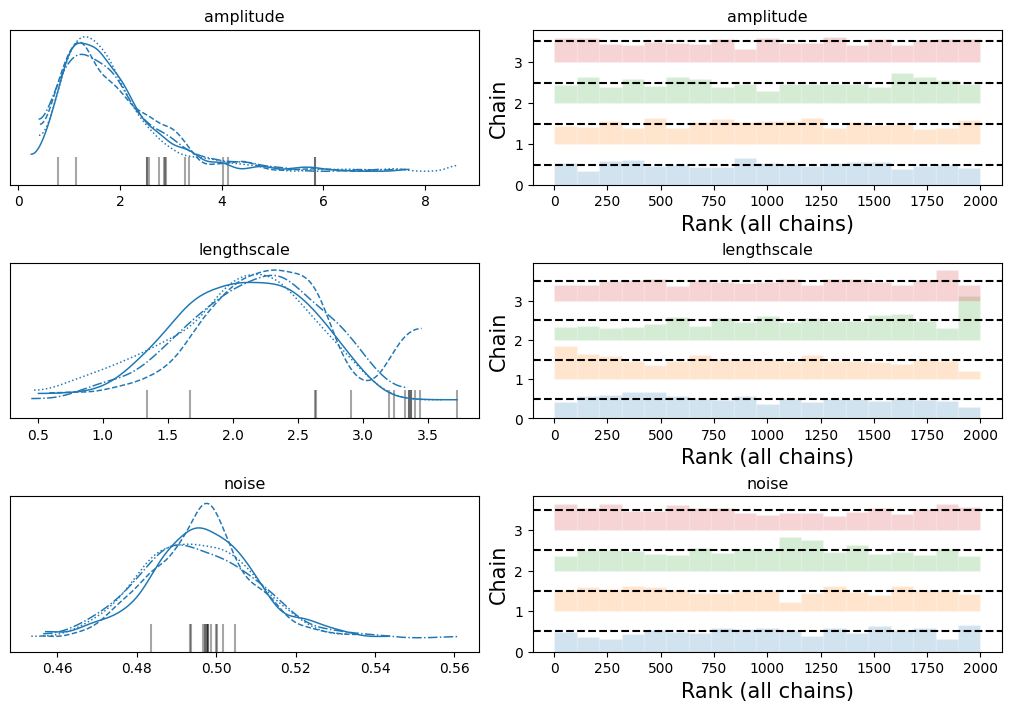

In [48]:
if INFERENCE == "mcmc":
    axes = az.plot_trace(
        data=idata_hsgp,
        var_names=VAR_NAMES,
        kind="rank_bars",
        backend_kwargs={"figsize": (10, 7), "layout": "constrained"},
    )

We can also overlay the posterior samples of ther kernel hyperparameters from the exact model and the approximation using `arviz`'s `plot_density` function.

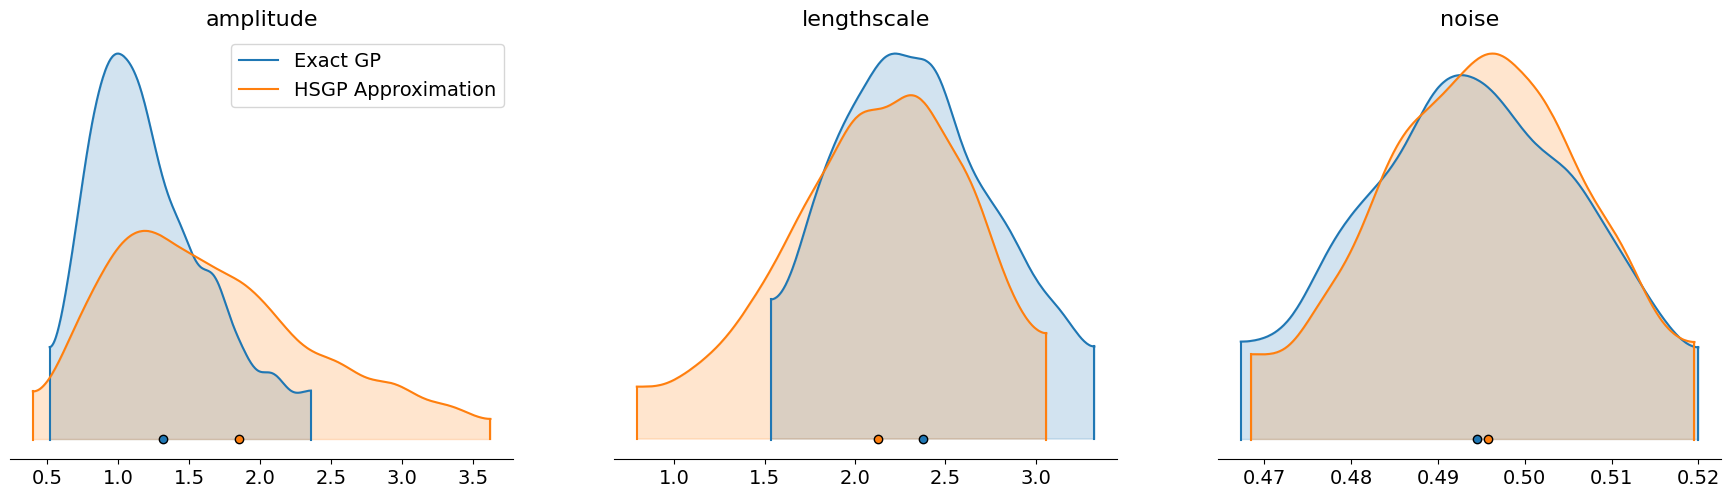

In [49]:
axes = az.plot_density(
    [idata, idata_hsgp],
    data_labels=["Exact GP", "HSGP Approximation"],
    var_names=VAR_NAMES,
    shade=0.2,
)

We can generate predictions for the grid points as above.

In [42]:
if INFERENCE == "mcmc":
    post_y_hsgp = posterior_predictive_mcmc(seed, hsgp_m.model, hsgp_mcmc, X=X_grid)
else:
    post_y_hsgp = posterior_predictive_svi(
        seed,
        hsgp_m.model,
        hsgp_guide,
        hsgp_res.params,
        X=X_grid,
    )

Like the exact model, the approximation accurately recovers the shape of the function and extrapolates well to the boundary.

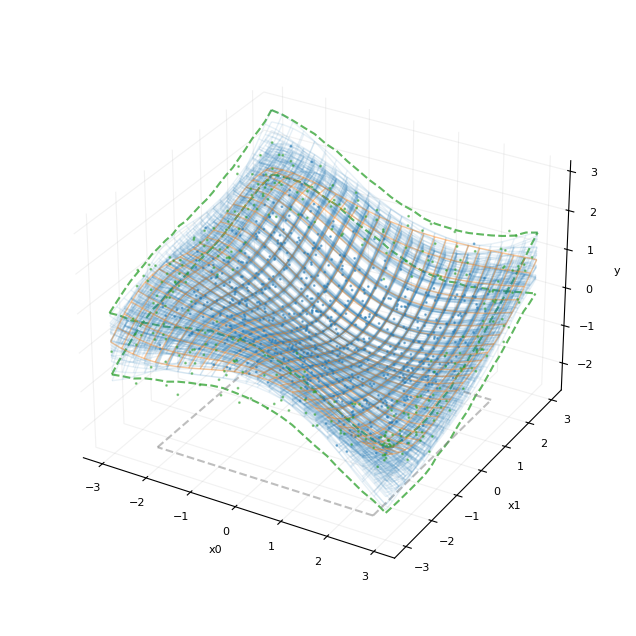

In [43]:
plot_fit_result(20, post_y_hsgp)
plt.show()

We can now compare the posterior predictive mean from the approximate model to the predictions from the exact model. We see the approximate model closely matches the exact model.

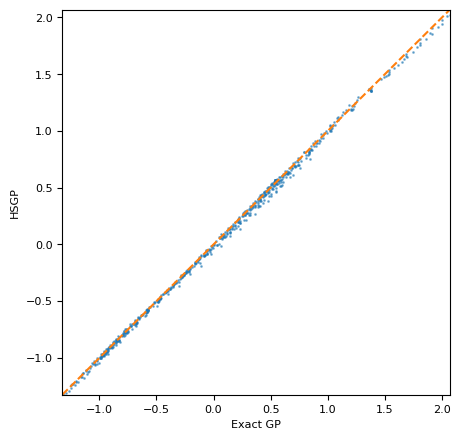

In [44]:
ax = plot_calibration(
    post_y["f_star"].mean(axis=0),
    post_y_hsgp["f_star"].mean(axis=0),
    point_size=1.0 if D == 2 else 5.0,
    x_label="Exact GP",
    y_label="HSGP",
)
plt.show()

And the approximate model performs well on the test set.

In [45]:
if INFERENCE == "mcmc":
    post_y_test_hsgp = posterior_predictive_mcmc(
        seed, hsgp_m.model, hsgp_mcmc, X=X_test
    )
else:
    post_y_test_hsgp = posterior_predictive_svi(
        seed, hsgp_m.model, hsgp_guide, hsgp_res.params, X=X_test
    )
print(
    "Test RMSE:",
    jnp.sqrt(jnp.mean((post_y_test_hsgp["y_test"].mean(axis=0) - y_test) ** 2)),
)

Test RMSE: 0.5634096306811304
